## Inserte token

# RED NEURONAL FEEDFORWARD O MLP

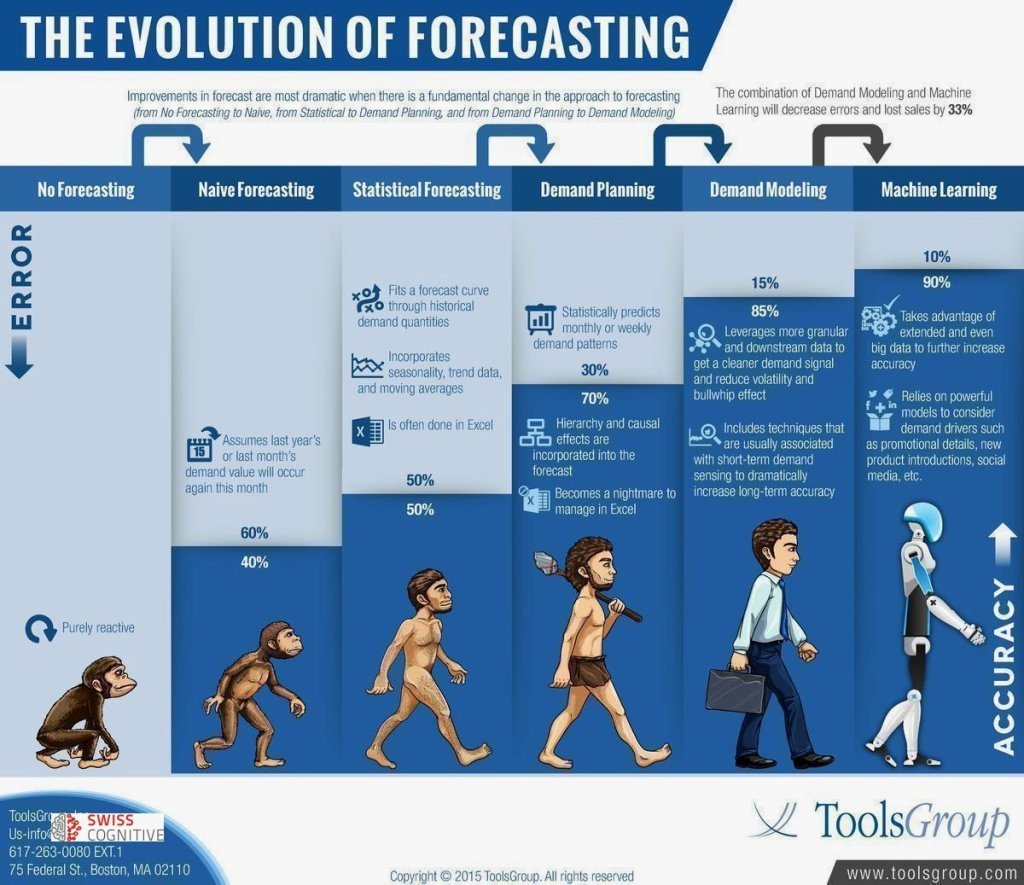

# Importamos librerías Keras y Tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(16,9)
plt.style.use('fast')
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler




# Cargar Dataset

# Seleccionamos Industria minera

Quitamos todos los trimestres del 2018 para poder predecirlos.

In [ ]:
df=df_data_1.iloc[0:43,2]
df

# Analizar estacionariedad.

In [ ]:
import statsmodels.api as sm
descomposicion = sm.tsa.seasonal_decompose(df,
                                                  model='additive', freq=4)  
fig = descomposicion.plot()


In [ ]:
plt.plot(df)
plt.title('Minería')
plt.show()

# Prueba de Dicky-Fuller Aumentada

H0:Raíz unitaria
H1: Estacionariedad no existe.

In [ ]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
import pandas as pd
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [ ]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

# Aplicar diferencias.

In [ ]:
df1=df.diff()
df2=df1[1:]
df2

In [ ]:
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(df2, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

# Preprocesado de los datos

Tomaremos nuestra serie temporal y la convertiremos en un problema del tipo supervisado para poder alimentar nuestra red neuronal y poder entrenarla con BackPropagation.

In [ ]:
PASOS=3
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df2 = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df2.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df2.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df2.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

Nuestras entradas serán las columnas encabezadas como var1(t-3), var1(t-2), var1(t-1) y nuestra salida será var1(t)

# División set de entrenamiento y Validación

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 40+4 - (12+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

Arquitectura de la red neuronal:
*Entrada 3 inputs
*1 capa oculta con 3 neuronas
*Salida una única neurona
*Función activación: tangente hiperbólica
*Utilizaremos como optimizador Adam y métrica de pérdida Mean Absolute Error
*Para calcular acuracy utilizaremos Mean Squared Error

In [ ]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

# Entrenamiento y Resultados

In [ ]:
EPOCHS=100
model = crear_modeloFF()
 
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)


# Visualizamos Resultados.

In [ ]:
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

# Pronóstico exportaciones futuras.

In [ ]:
ultimosTrimestres=df[36:43]
ultimosTrimestres

Mismo preprocesado de los datos que hciimos para el entrenamiento pero esta vez sin inluir la columna de salida Y, pues es lo que queremos hallar. 

In [ ]:
values = ultimosTrimestres.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[3]], axis=1, inplace=True)
reframed.head(3)

In [ ]:
values = reframed.values
x_test = values[2:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

In [ ]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test
 
results=[]
for i in range(4):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

In [ ]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

In [ ]:
prediccion = pd.DataFrame(inverted)
prediccion.columns = ['pronostico']
prediccion.plot()
prediccion.to_csv('pronostico.csv')

# Deployment

Obtenemos las credenciales de nuestro servicio de Machine learning

In [ ]:
WML_CREDENTIALS={
    
}

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)


Clean up

In [ ]:
for r in client.repository.get_model_details()['resources']:
    if r['entity']['name'] == 'MLP-SECTORES-DEPLOYMENT ':
        guid_to_delete = r['metadata']['guid']
        print('Deleting model: ' + str(guid_to_delete))
        client.repository.delete(guid_to_delete)


In [ ]:
sample_payload = { "values" : [[[0.67736673, 0.81217957, 0.53382635]],[[0.81217957, 0.53382635, 0.35427094]]]}

In [ ]:
import os

In [ ]:
filename = 'complain_model.h5'
model.save(filename)

#compress keras model
tar_filename = filename + ".tgz"
cmdstring = "tar -zcvf " + tar_filename + " " + filename
os.system(cmdstring);
!ls -lat

In [ ]:
project.get_storage_metadata()

In [ ]:
model_props = {
    client.repository.ModelMetaNames.NAME: "MLP-SECTORES-MODEL",
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.5",
    client.repository.ModelMetaNames.RUNTIME_NAME: "python",
    client.repository.ModelMetaNames.RUNTIME_VERSION: "3.5",
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.2.4'}]
}

published_model_details = client.repository.store_model(model=tar_filename, meta_props=model_props)

In [ ]:
model_uid = client.repository.get_model_uid(published_model_details)
print(model_uid)

In [ ]:
deployment = client.deployments.create(model_uid, 'MLP-SECTORES-DEPLOYMENT')

In [ ]:
client.deployments.list()

In [ ]:
scoring_endpoint = client.deployments.get_scoring_url(deployment)
print(scoring_endpoint)

In [ ]:

score = client.deployments.score(scoring_endpoint, sample_payload )
print(score)
